# Prediction Of Close Prices for Cryptocurrency

Cryptocurrency is future of currency and how we do trading. Cryptocurrencies are there from 2013,but at that time people were not interested in decentralized currencies.But due to recent rise of technology and makrket changes, now everyone want to buy cryptocurrency. 

So today we are going to try to predict the close prices of top three cryptocurrencies using deep learning. Predicting the exact prices is not a simple task. Lot of factors affect the prices next day,but to make things simple here we are just using the Close,Open,High,Low,Volume and Market Cap as features to predict the close price for next day. The data is fetched from https://coinmarketcap.com/ .

We will start by importing some useful python packeges. We will use them in our data preparation and model creation and prediction as well.

In [1]:
import pandas as pd
import time
import seaborn as sns
import datetime
import numpy as np
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation, Dense

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Bitcoin

Bitcoins is the oldest cryptocurrency is the market. We can say the oldest got much costlier than it was before. We will fetch the data of bitcoin from this url https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end. It is all time data of Bitcoin starting from 2013 to 2018 present day. There are some missing values in data which we will replace with zero for our model building purpose.

In [2]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info=bitcoin_market_info[['Date','Close','Open','High','Low','Volume','Market Cap']]
bitcoin_market_info.head()

,Date,Close,Open,High,Low,Volume,Market Cap
0,2018-01-30,10106.3,11306.8,11307.2,10036.2,8637860000,190339000000
1,2018-01-29,11296.4,11755.5,11875.6,11179.2,7107360000,197871000000
2,2018-01-28,11786.3,11475.3,12040.3,11475.3,8350360000,193133000000
3,2018-01-27,11440.7,11174.9,11614.9,10989.2,7583270000,188054000000
4,2018-01-26,11171.4,11256.0,11656.7,10470.3,9746200000,189398000000


The above values are first five days data.AS you can see have latest data from 24 January 2018. So ultimately we are using up to date data for building our model. 

Now let's normalize the data. As you can see that the values in data are ranging from some 10,000 USD up to some 183,419,000,000, which is really big number to deal with.So we will noramlize data using scikit-learn minmax normalization module. It will normalize the data with mean zero and standard deviation one. Then we can use the data to further processign and model training. 

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


bitcoin_market_info.drop(['Date'],inplace=True,axis=1)
#print(bitcoin_market_info.head())
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(bitcoin_market_info)

In the time series data, data preparation is key part. We can not just use the data directly to train model. So we will twick the data slightly according to our requirment. 

What we are going to do is like this, we will shift each of the column to one step forward. So for example if the data is of 1 Januar,2018 then the output of that paerticularrow should be data of 2 January,2018. This way we will give present data as input and the future data as output.

For doing the above step we are going to define a function which will take care of what we want. It will also drop rows with NaN values,so if we end up with NaN values then also we do not have to worry about it. The details regarding this function can be found here https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/ . 

In [4]:
columns=bitcoin_market_info.columns
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(-i))
		names += [(j) for j in columns]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(i))
		if i == 0:
			names += [("output "+j) for j in columns]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Now we will use above defined function to reframe our original data.

In [5]:
reframed = series_to_supervised(scaled, 1, 1)
ref=series_to_supervised(bitcoin_market_info.values,1,1)
ref.drop(ref.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(ref.head())

     Close     Open     High      Low        Volume    Market Cap  \
0  11296.4  11755.5  11875.6  11179.2  7.107360e+09  1.978710e+11   
1  11786.3  11475.3  12040.3  11475.3  8.350360e+09  1.931330e+11   
2  11440.7  11174.9  11614.9  10989.2  7.583270e+09  1.880540e+11   
3  11171.4  11256.0  11656.7  10470.3  9.746200e+09  1.893980e+11   
4  11259.4  11421.7  11785.7  11057.4  8.873170e+09  1.921630e+11   

   output Close  
0       10106.3  
1       11296.4  
2       11786.3  
3       11440.7  
4       11171.4  


In [6]:
print(reframed.shape)
print(bitcoin_market_info.shape)

(1738, 12)
(1739, 6)


You can see the shape of reframed data is different than original data. As now we have stacked next day data to our present day data as output. So we end up with 12 columns instead of 6 as it was in original data. But we do not want to predict all the values for future days. We just want to predict the close price of the next day. So we are going to drop other unnecessary columns from our reframed data. 

Below is the first five rows of our noramlized as well as reframed data.

In [7]:
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

      Close      Open      High       Low    Volume  Market Cap  output Close
0  0.577898  0.602196  0.589626  0.587758  0.298116    0.605762      0.516644
1  0.603113  0.587758  0.597855  0.603418  0.350254    0.591200      0.577898
2  0.585325  0.572280  0.576601  0.577710  0.318078    0.575589      0.603113
3  0.571465  0.576458  0.578689  0.550267  0.408802    0.579720      0.585325
4  0.575994  0.584996  0.585135  0.581317  0.372183    0.588218      0.571465


Now we will separate the data into two groups as training set and test set. We are having 1732 number of examples. So we will use 1500 number ofsamples for trainingpart and then rest of the data as testing part and model evaluation. We will also set the output y as the last column of our data. 

After splitting we are going to reshape the data into three dimensional shape so that we can use it for training a model. The new shape of the data will be (number of samples * 1 * number of features ). We will follow this shape up to the end of prediction and before feeding data to our model we will normalize and reshape it. 

In [8]:
values=reframed.values
train = values[9:1500, :]
test = values[1500:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1491, 1, 6) (1491,) (238, 1, 6) (238,)


Now we have noramlized the data, we have reframed it as supervised learning time-series data, and also we have splitted it in to two groups as well. So it is time to build and train the model. 

Below is the code for building a model. We are going to use Keras framework to build,train, and predictions. Keras is high level API wrapper framework, so we will be using Tensorflow as backend to it. 

We are going to use LSTM(Long Short Term Memory) network whichis kind of RNN(Recurrent Neural Network). RNN are widely and most popular neural networkl when it comesto time-series data. You can read more about RNN https://en.wikipedia.org/wiki/Recurrent_neural_network on this wikipedia page. If you like then you can read more about LSTM https://en.wikipedia.org/wiki/Long_short-term_memory here on its wikipedia page. 

In our LSTM there will be  using 80 number of neurons. And we will plot the loss of our training and testing set with respect to numbeer of epochs. We will use ADAM Optimizer to train the network and the Mean Absolute Error loss as loss function. We will train the network for 50 epochs and then will validate it on test set. 

Train on 1491 samples, validate on 238 samples
Epoch 1/50
 - 2s - loss: 0.0678 - val_loss: 0.0081
Epoch 2/50
 - 0s - loss: 0.0551 - val_loss: 0.0064
Epoch 3/50
 - 0s - loss: 0.0417 - val_loss: 0.0073
Epoch 4/50
 - 0s - loss: 0.0281 - val_loss: 0.0100
Epoch 5/50
 - 0s - loss: 0.0107 - val_loss: 0.0043
Epoch 6/50
 - 0s - loss: 0.0070 - val_loss: 0.0045
Epoch 7/50
 - 0s - loss: 0.0061 - val_loss: 0.0035
Epoch 8/50
 - 0s - loss: 0.0058 - val_loss: 0.0032
Epoch 9/50
 - 0s - loss: 0.0051 - val_loss: 0.0036
Epoch 10/50
 - 0s - loss: 0.0049 - val_loss: 0.0045
Epoch 11/50
 - 0s - loss: 0.0053 - val_loss: 0.0028
Epoch 12/50
 - 1s - loss: 0.0044 - val_loss: 0.0035
Epoch 13/50
 - 1s - loss: 0.0046 - val_loss: 0.0018
Epoch 14/50
 - 1s - loss: 0.0042 - val_loss: 0.0029
Epoch 15/50
 - 1s - loss: 0.0043 - val_loss: 0.0015
Epoch 16/50
 - 1s - loss: 0.0043 - val_loss: 0.0025
Epoch 17/50
 - 1s - loss: 0.0043 - val_loss: 0.0018
Epoch 18/50
 - 1s - loss: 0.0040 - val_loss: 0.0025
Epoch 19/50
 - 1s - loss: 

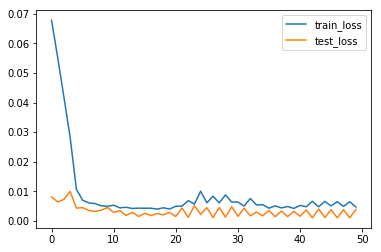

In [9]:
# design network
model = Sequential()
model.add(LSTM(80, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

Now we will see how our model is performing on test set data. We will use RMSE metric to see how it generalize on test set. 

In [10]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse =sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 80.293


The error is around 56 on test set.

Now let's predict some close price on data to see how far we are in predicting exact prices. We will be using data from 21 January to 26 January 2018 as input data. So the predicted prices should be of 22 January to 27 January 2018. Here we will normalize the data before feeding into model for prediction but we are not going to reframe it because it is 7 days data and we can write close for 6 days by hand easily.

In [11]:
data=np.array([[11171.4 ,11256.0 ,11656.7 ,10470.3 ,9746200000 ,189398000000],
           [11259.4 ,11421.7 ,11785.7 ,11057.4 ,8873170000 ,192163000000],
           [11359.4 ,10903.4 ,11501.4 ,10639.8 ,9940990000 ,183419000000],
           [10868.40,10944.50 ,11377.60,10129.70, 9660610000 ,184087000000],
           [10931.40,11633.10,11966.40,10240.20,10537400000 ,195645000000],
           [11600.10,12889.20,12895.90,11288.20,9935180000,216740000000]])
a=scaler.fit_transform(data)
pre=model.predict(a.reshape(data.shape[0],1,6))
phat=np.concatenate((pre,a[:,1:]),axis=1)
#print(phat)
predicted=scaler.inverse_transform(phat)
#print(predicted)

In [12]:
real_close=[11440.7,11171.4,11259.4,11359.4,10868.4,10931.4]
predicted_close=[]
date=[]
difference=[]
pr_change=[]
date=pd.date_range('22-01-2018','27-01-2018',freq='D').sort_values(ascending=False)
#print(difference)
for i in range(data.shape[0]):
    predicted_close.append(predicted[i,0])
    difference.append(abs(predicted[i,0]-real_close[i]))
    pr_change.append((abs(predicted[i,0]-real_close[i])/predicted[i,0])*100)
df=pd.DataFrame({'Date':date})
df['real_close']=real_close
df['predicted_close']=predicted_close
df['Difference']=difference
df['Percentage_change']=pr_change
print(df)

        Date  real_close  predicted_close  Difference  Percentage_change
0 2018-01-27     11440.7     11063.942378  376.757622           3.405275
1 2018-01-26     11171.4     11179.975127    8.575127           0.076701
2 2018-01-25     11259.4     11084.504597  174.895403           1.577837
3 2018-01-24     11359.4     10889.756080  469.643920           4.312713
4 2018-01-23     10868.4     11051.979910  183.579910           1.661059
5 2018-01-22     10931.4     11518.351797  586.951797           5.095797


In the above dataframe we can see the dates,real close price on that date,predicted price on that date,difference between real and predicted price and the percentage change between real and predicted prices.

The highest difference between the real close and predicted close is around 697 USD approx which is good for simple model that we have created. In terms of percentage it is around 6% which is also a good.

Now let's try the same approach on the second costliest currency i.e., Ethereum . 

# Ethereum 

All steps are same as previous one. Just instead of Bitcoin now we are gong to use Ethereum data for train and testing model and then we will predict prices of 7 days for Ethereum as we previously have done for Bitcoin.

We will directly jump on prediction part and let's see how we are doing on Ethereum.

In [13]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
eth_market_info.loc[eth_market_info['Market Cap']=="-",'Market Cap']=0
# convert to int
eth_market_info['Volume'] = eth_market_info['Volume'].astype('int64')
# look at the first few rows
eth_market_info=eth_market_info[['Date','Close','Open','High','Low','Volume','Market Cap']]
eth_market_info.head()

,Date,Close,Open,High,Low,Volume,Market Cap
0,2018-01-30,1071.13,1184.13,1184.63,1058.97,4107860000,115207000000
1,2018-01-29,1182.36,1246.70,1256.70,1169.08,3715080000,121269000000
2,2018-01-28,1246.01,1111.78,1257.77,1111.78,5372330000,108122000000
3,2018-01-27,1107.07,1055.75,1121.98,1042.12,3002870000,102651000000
4,2018-01-26,1055.17,1052.70,1080.60,996.78,3617690000,102334000000


In [14]:
eth_market_info.drop(['Date'],inplace=True,axis=1)
scaler_eth = MinMaxScaler(feature_range=(0, 1))
scaled_eth = scaler_eth.fit_transform(eth_market_info)
#print(scaled_eth)

In [15]:
reframed_eth = series_to_supervised(scaled_eth, 1, 1)
print(reframed_eth.shape)
print(eth_market_info.shape)

(907, 12)
(908, 6)


In [16]:
reframed_eth.drop(reframed_eth.columns[[7,8,9,10,11]], axis=1, inplace=True)
values_eth=reframed_eth.values
train_eth = values_eth[10:800, :]
test_eth = values_eth[800:, :]
# split into input and outputs
train_X_eth, train_y_eth = train_eth[:, :-1], train_eth[:, -1]
test_X_eth, test_y_eth = test_eth[:, :-1], test_eth[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X_eth = train_X_eth.reshape((train_X_eth.shape[0], 1, train_X_eth.shape[1]))
test_X_eth = test_X_eth.reshape((test_X_eth.shape[0], 1, test_X_eth.shape[1]))
print(train_X_eth.shape, train_y_eth.shape, test_X_eth.shape, test_y_eth.shape)

(790, 1, 6) (790,) (107, 1, 6) (107,)


Train on 790 samples, validate on 107 samples
Epoch 1/50
 - 1s - loss: 0.1096 - val_loss: 0.0177
Epoch 2/50
 - 0s - loss: 0.0818 - val_loss: 0.0011
Epoch 3/50
 - 0s - loss: 0.0694 - val_loss: 0.0018
Epoch 4/50
 - 0s - loss: 0.0496 - val_loss: 1.1625e-04
Epoch 5/50
 - 0s - loss: 0.0276 - val_loss: 0.0055
Epoch 6/50
 - 0s - loss: 0.0089 - val_loss: 1.1935e-04
Epoch 7/50
 - 0s - loss: 0.0090 - val_loss: 0.0012
Epoch 8/50
 - 0s - loss: 0.0093 - val_loss: 0.0015
Epoch 9/50
 - 0s - loss: 0.0103 - val_loss: 0.0024
Epoch 10/50
 - 0s - loss: 0.0080 - val_loss: 7.3856e-04
Epoch 11/50
 - 0s - loss: 0.0115 - val_loss: 0.0011
Epoch 12/50
 - 0s - loss: 0.0078 - val_loss: 0.0014
Epoch 13/50
 - 0s - loss: 0.0094 - val_loss: 5.9940e-04
Epoch 14/50
 - 0s - loss: 0.0129 - val_loss: 2.2799e-04
Epoch 15/50
 - 0s - loss: 0.0079 - val_loss: 1.7962e-04
Epoch 16/50
 - 0s - loss: 0.0114 - val_loss: 0.0013
Epoch 17/50
 - 0s - loss: 0.0080 - val_loss: 7.9809e-04
Epoch 18/50
 - 0s - loss: 0.0133 - val_loss: 0.0024

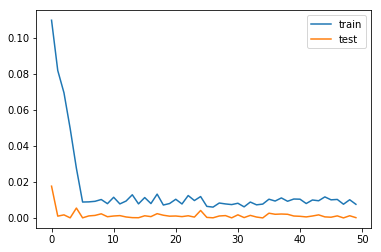

In [17]:
# design network
model = Sequential()
model.add(LSTM(70, input_shape=(train_X_eth.shape[1], train_X_eth.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X_eth, train_y_eth, epochs=50, batch_size=32, validation_data=(test_X_eth, test_y_eth), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
# make a prediction
yhat_eth = model.predict(test_X_eth)
test_X_eth = test_X_eth.reshape((test_X_eth.shape[0], test_X_eth.shape[2]))
# invert scaling for forecast
inv_yhat_eth = np.concatenate((yhat_eth, test_X_eth[:, 1:]), axis=1)
inv_yhat_eth = scaler_eth.inverse_transform(inv_yhat_eth)
inv_yhat_eth = inv_yhat_eth[:,0]
# invert scaling for actual
test_y_eth = test_y_eth.reshape((len(test_y_eth), 1))
inv_y_eth = np.concatenate((test_y_eth, test_X_eth[:, 1:]), axis=1)
inv_y_eth = scaler_eth.inverse_transform(inv_y_eth)
inv_y_eth = inv_y_eth[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_eth, inv_yhat_eth))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.388


We will use 6 days data from 21 January up to 26 January 2018 and we will get the predicted prices for 22 January up to 27 January 2018. Here also we will just normalize the data and the we will write down the future pricesby hand. No reframe of data will be done. 

In [19]:
data_eth=np.array([[1055.17 ,1052.70 ,1080.60 ,996.78 ,3617690000 ,102334000000],
           [1056.03,1063.22 ,1104.66 ,1034.74 ,4050190000 ,103335000000],
           [1058.78 ,987.48 ,1062.44 ,965.81 ,3944040000 ,95952700000],
           [986.23,1004.17,1023.23,920.54,3556700000 ,97554300000],
           [1003.26,1055.35,1089.10,930.74 ,3810100000,102504000000],
           [1049.58,1155.68,1155.68,1021.50 ,3378090000,112226000000]])
a_eth=scaler_eth.fit_transform(data_eth)
pre=model.predict(a_eth.reshape(data_eth.shape[0],1,6))
phat_eth=np.concatenate((pre,a_eth[:,1:]),axis=1)
#print(phat)
predicted_eth=scaler_eth.inverse_transform(phat_eth)

In [20]:
real_close_eth=np.array([1107.07,1055.17,1056.03,1058.78,986.23,1003.26])
predicted_close_eth=[]
difference_eth=[]
pr_change_eth=[]
date_eth=pd.date_range('22-01-2018','27-01-2018',freq='D').sort_values(ascending=False)
#print(date_eth)
for i in range(data_eth.shape[0]):
    predicted_close_eth.append(predicted_eth[i,0])
    difference_eth.append(abs(predicted_eth[i,0]-real_close_eth[i]))
    pr_change_eth.append((abs(predicted_eth[i,0]-real_close_eth[i])/predicted_eth[i,0])*100)
df_eth=pd.DataFrame({'Date':date_eth})
df_eth['real_close']=real_close_eth
df_eth['predicted_close']=predicted_close_eth
df_eth['Difference']=difference_eth
df_eth['Percentage_change']=pr_change_eth
print(df_eth)

        Date  real_close  predicted_close  Difference  Percentage_change
0 2018-01-27     1107.07      1031.217262   75.852738           7.355651
1 2018-01-26     1055.17      1043.460225   11.709775           1.122206
2 2018-01-25     1056.03      1017.195504   38.834496           3.817801
3 2018-01-24     1058.78       990.543651   68.236349           6.888778
4 2018-01-23      986.23      1014.219137   27.989137           2.759674
5 2018-01-22     1003.26      1055.321891   52.061891           4.933271


In the above dataframe we can see that the real and predicted prices are really close to each other. The highest difference is 90 USD approx with 9% approx change or difference. Though for model with this much complexity it is realy good. 

Now let's do one more example on Ripple which is the third highest rated cryptocurrency in the world right now. 

# Ripple

Here we will fetch the data of Ripple and then we will trian LSTM to predict future close prices. We will see how our model is doing in terms of perfroramce on 7 days of data.

We are skipping the explaination of code blocks here as it is mostly similar to Bitcoin one. So let's jump on prediction part and see how our model predicts prices for future day using present data.

In [21]:
ripple_market_info = pd.read_html("https://coinmarketcap.com/currencies/ripple/historical-data/?start=20130428&end=20180124"+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
ripple_market_info = ripple_market_info.assign(Date=pd.to_datetime(ripple_market_info['Date']))
# when Volume is equal to '-' convert it to 0
ripple_market_info.loc[ripple_market_info['Volume']=="-",'Volume']=0
# convert to int
ripple_market_info['Volume'] = ripple_market_info['Volume'].astype('int64')
# look at the first few rows
ripple_market_info=ripple_market_info[['Date','Close','Open','High','Low','Volume','Market Cap']]
ripple_market_info.head()

,Date,Close,Open,High,Low,Volume,Market Cap
0,2018-01-30,1.14,1.33,1.33,1.13,1134640000,51452400000
1,2018-01-29,1.32,1.40,1.41,1.30,1073680000,54204300000
2,2018-01-28,1.40,1.22,1.44,1.22,1327360000,47412500000
3,2018-01-27,1.22,1.22,1.24,1.19,689101000,47180200000
4,2018-01-26,1.22,1.31,1.33,1.14,2037570000,50706400000


In [22]:
ripple_market_info.drop(['Date'],inplace=True,axis=1)
scaler_rip = MinMaxScaler(feature_range=(0, 1))
scaled_rip = scaler_rip.fit_transform(ripple_market_info)
#print(scaled_rip)

In [23]:
reframed_rip = series_to_supervised(scaled_rip, 1, 1)
print(reframed_rip.shape)
print(ripple_market_info.shape)

(1640, 12)
(1641, 6)


In [24]:
reframed_rip.drop(reframed_rip.columns[[7,8,9,10,11]], axis=1, inplace=True)
values_rip=reframed_rip.values
train_rip = values_rip[10:1500, :]
test_rip = values_rip[1500:, :]
# split into input and outputs
train_X_rip, train_y_rip = train_rip[:, :-1], train_rip[:, -1]
test_X_rip, test_y_rip = test_rip[:, :-1], test_rip[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X_rip = train_X_rip.reshape((train_X_rip.shape[0], 1, train_X_rip.shape[1]))
test_X_rip = test_X_rip.reshape((test_X_rip.shape[0], 1, test_X_rip.shape[1]))
print(train_X_rip.shape, train_y_rip.shape, test_X_rip.shape, test_y_rip.shape)

(1490, 1, 6) (1490,) (140, 1, 6) (140,)


Train on 1490 samples, validate on 140 samples
Epoch 1/50
 - 2s - loss: 0.0296 - val_loss: 0.0022
Epoch 2/50
 - 1s - loss: 0.0226 - val_loss: 0.0016
Epoch 3/50
 - 1s - loss: 0.0187 - val_loss: 0.0021
Epoch 4/50
 - 1s - loss: 0.0128 - val_loss: 0.0025
Epoch 5/50
 - 1s - loss: 0.0083 - val_loss: 0.0016
Epoch 6/50
 - 1s - loss: 0.0044 - val_loss: 0.0022
Epoch 7/50
 - 1s - loss: 0.0047 - val_loss: 7.8320e-04
Epoch 8/50
 - 1s - loss: 0.0048 - val_loss: 0.0015
Epoch 9/50
 - 1s - loss: 0.0037 - val_loss: 0.0013
Epoch 10/50
 - 1s - loss: 0.0044 - val_loss: 0.0018
Epoch 11/50
 - 1s - loss: 0.0040 - val_loss: 0.0019
Epoch 12/50
 - 1s - loss: 0.0038 - val_loss: 0.0020
Epoch 13/50
 - 1s - loss: 0.0034 - val_loss: 0.0017
Epoch 14/50
 - 1s - loss: 0.0036 - val_loss: 0.0016
Epoch 15/50
 - 1s - loss: 0.0038 - val_loss: 0.0016
Epoch 16/50
 - 1s - loss: 0.0036 - val_loss: 0.0014
Epoch 17/50
 - 1s - loss: 0.0038 - val_loss: 9.0783e-04
Epoch 18/50
 - 1s - loss: 0.0034 - val_loss: 0.0020
Epoch 19/50
 - 1s 

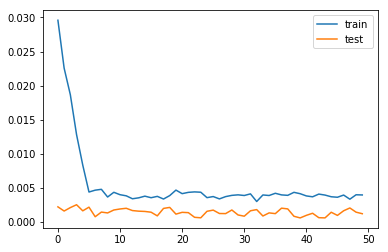

In [25]:
# design network
model = Sequential()
model.add(LSTM(75, input_shape=(train_X_rip.shape[1], train_X_rip.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X_rip, train_y_rip, epochs=50, batch_size=32, validation_data=(test_X_rip, test_y_rip), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [26]:
# make a prediction
yhat_rip = model.predict(test_X_rip)
test_X_rip = test_X_rip.reshape((test_X_rip.shape[0], test_X_rip.shape[2]))
# invert scaling for forecast
inv_yhat_rip = np.concatenate((yhat_rip, test_X_rip[:, 1:]), axis=1)
inv_yhat_rip = scaler_rip.inverse_transform(inv_yhat_rip)
inv_yhat_rip = inv_yhat_rip[:,0]
# invert scaling for actual
test_y_rip = test_y_rip.reshape((len(test_y_rip), 1))
inv_y_rip = np.concatenate((test_y_rip, test_X_rip[:, 1:]), axis=1)
inv_y_rip = scaler_rip.inverse_transform(inv_y_rip)
inv_y_rip = inv_y_rip[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_rip, inv_yhat_rip))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.005


For Ripple our RMSE is really close to zero, which is good according to our simple model.

Now let's make some prediction. This time we are taking data from 21 January to 26 January,2018 so the predicted prices will be from the day 22 January to 27 January ,2018. At last we will compare the real prices and the predicted prices with difference and percentage change between real and predicted prices. 

In [27]:
data_rip=np.array([[1.22 ,1.31 ,1.33 ,1.14 ,2037570000 ,50706400000],
           [1.31 ,1.36 ,1.38 ,1.29 ,986068000 ,52811100000],
           [1.36,1.35 ,1.42 ,1.31 ,1853440000 ,52380100000],
           [1.34 ,1.35 ,1.43 ,1.20 ,2977080000 ,52421300000],
           [1.36 ,1.39 ,1.43 ,1.16 ,2642510000 ,53909800000],
           [1.38 ,1.58 ,1.58 ,1.34 ,2840750000 ,61061900000]])
a_rip=scaler_rip.fit_transform(data_rip)
pre_rip=model.predict(a_rip.reshape(data_rip.shape[0],1,6))
phat_rip=np.concatenate((pre_rip,a_rip[:,1:]),axis=1)
#print(phat)
predicted_rip=scaler_rip.inverse_transform(phat_rip)

In [28]:
real_close_rip=[1.22,1.22,1.31,1.36,1.34,1.36]
predicted_close_rip=[]
difference_rip=[]
pr_change_rip=[]
dates=pd.date_range(start='01-22-2018',end='01-27-2018',freq='D').sort_values(ascending=False)
#print(dates)
for i in range(data_rip.shape[0]):
    predicted_close_rip.append(predicted_rip[i,0])
    difference_rip.append(abs(predicted_rip[i,0]-real_close_rip[i]))
    pr_change_rip.append((abs(predicted_rip[i,0]-real_close_rip[i])/predicted_rip[i,0])*100)
val=np.array(pr_change_rip)
val=np.mean(val,axis=0)
#print(val)
df_rip=pd.DataFrame({'Date':dates})
df_rip['real_close']=real_close_rip
df_rip['predicted_close']=predicted_close_rip
df_rip['Difference']=difference_rip
df_rip['Percentage_change']=pr_change_rip
print(df_rip)

        Date  real_close  predicted_close  Difference  Percentage_change
0 2018-01-27        1.22         1.225445    0.005445           0.444338
1 2018-01-26        1.22         1.278812    0.058812           4.598951
2 2018-01-25        1.31         1.302409    0.007591           0.582861
3 2018-01-24        1.36         1.287979    0.072021           5.591792
4 2018-01-23        1.34         1.291882    0.048118           3.724678
5 2018-01-22        1.36         1.366644    0.006644           0.486137


In the above dataframe we can see the real close prices and the predicted prices are realy close to each other.The highest percnetage change is 14% approx. which is really good as per the amount of data and the size of model that we have.

This way we can now predict the future close price of three major cryptocurencies with ease. But remember this is just simplest approach that we can go for. Predicting the prices is really dificult task as lot of factors in world determines the price of any curency. So we can not gurrentee that our approach is best or will give us best results. 